suggestion for using TF Object Detection
https://medium.com/@anthony_sarkis/self-driving-cars-implementing-real-time-traffic-light-detection-and-classification-in-2017-7d9ae8df1c58

Google's Approach to traffic light
https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/37259.pdf

SqueezeNet trained on ImageNet
https://medium.freecodecamp.org/recognizing-traffic-lights-with-deep-learning-23dae23287cc

Convert Caffe Models to TF
https://github.com/ethereon/caffe-tensorflow

Transfer Learning using Keras (blog)
https://towardsdatascience.com/transfer-learning-using-keras-d804b2e04ef8



## Imports

In [19]:
# So we can see the output of multiple variables in a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
from tqdm import tqdm
from collections import namedtuple

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import tensorflow as tf
from scipy.ndimage import imread
from skimage.transform import resize
from sklearn.utils import shuffle

## Load Data

In [7]:
path = './data/just-traffic-lights'

image_paths = []
for root, dirs, files in os.walk(path):
    for file in files:
        image_paths.append(os.path.join(root,file))

In [16]:
# create validation train and test set
image_paths = shuffle(image_paths)

train_image_paths = image_paths[:-100]
test_image_paths = image_paths[-100:]
print('number of train images \t{:>5}'.format(len(train_image_paths)))
print('number of test images \t{:>5}'.format(len(test_image_paths)))

number of train images 	  972
number of test images 	  100


In [63]:
def create_indices(image_paths):
    """
    0 = none
    1 = green
    2 = yellow
    3 = red
    
    :return :
    {'./data/just-traffic-lights/real/Green/001094.png': 1}
    """

    ind_dict = {}
    for img in image_paths:
        if "No" in img: 
            ind_dict[img] = 0
        if "Green" in img: 
            ind_dict[img] = 1
        if "Yellow" in img: 
            ind_dict[img] = 2
        if "Red" in img: 
            ind_dict[img] = 3
            
    return ind_dict

def get_one_hot(image_paths, ver='keras'):
    
    ind = create_indices(image_paths)
    ind = [ind for key,ind in ind.items()]
    
    # tf version
    if ver=='tf':
        one_hot = tf.one_hot(ind, num_classes)
    
    # keras version
    if ver=="keras":
        one_hot = keras.utils.to_categorical(ind, num_classes=num_classes)
    
    return one_hot

# test out one_hot
get_one_hot(image_paths[:5])

array([[ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.]])

## generator configs

In [64]:
Image_Size = namedtuple('Image_Size', 'x y ch')
image_size = Image_Size(x=50, y=50, ch=3)
num_classes = 4

In [65]:
def generator(samples, batch_size=1, verbose=False):
    shuffle(samples)
    num_samples = len(samples)
    
    for offset in range(0, num_samples, batch_size):
        
        # get a batch of image_paths
        x_batch_paths = samples[offset : offset+batch_size]
        x_batch = []
        for img_path in x_batch_paths:
            img = imread(img_path)
            new_shape = resize(img, (image_size.x, image_size.y)) 
            x_batch.append(new_shape)
            
        # reshape images to 4D: (batch_size, row, col, chs)
        x_batch = np.array(x_batch)
        x_batch = x_batch.reshape(batch_size, image_size.x, image_size.y, image_size.ch)
        
        # get one-hot-encode labels based on path name
        y_batch = get_one_hot(x_batch_paths)

        assert len(y_batch) == len(x_batch),'Wrong Match {} {}'.format(len(y_batch), len(x_batch))
        yield (x_batch, y_batch)

In [87]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    fill_mode = "nearest",
    shear_range = 0.5,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    rotation_range=5)

In [67]:
valid_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = False,
    fill_mode = "nearest",
    zoom_range = 0.0,
    width_shift_range = 0.0,
    height_shift_range=0.0,
    rotation_range=0)

In [69]:
x_train, y_train = next(generator(train_image_paths, batch_size=972))
x_test, y_test = next(generator(test_image_paths, batch_size=100))

train_gen = train_datagen.flow(x=x_train, y=y_train)
test_gen = train_datagen.flow(x=x_test, y=y_test)

x_train.shape
y_train.shape

x_test.shape
y_test.shape

/Users/topher/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(972, 50, 50, 3)

(972, 4)

(100, 50, 50, 3)

(100, 4)

In [73]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(image_size.x, image_size.y, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 33856)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               4333696   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

In [83]:
# samples_per_epoch = len(images_paths)
nb_val_samples = 10
nb_max_epoch = 5
steps_per_epoch = 32

hist = model.fit_generator(
    generator=train_gen, 
    steps_per_epoch=steps_per_epoch, # number of samples of your dataset divided by the batch size
    epochs=nb_max_epoch,
    validation_data=test_gen,
    use_multiprocessing=True,
    initial_epoch=3)
    

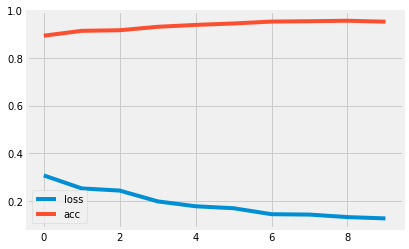

In [179]:
acc = hist.history['acc']
loss = hist.history['loss']
plt.plot(loss)
plt.plot(acc)
plt.legend(['loss', 'acc'])
plt.show();